Датасет: https://www.kaggle.com/datasets/retailrocket/ecommerce-dataset?resource=download

In [18]:
import sqlite3 # импортируем базу данных
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

plt.style.use('dark_background')

In [19]:
sqlite3.sqlite_version

'3.37.2'

In [20]:
con = sqlite3.connect("db") # подключаемся к базе данных

In [21]:
# считываем все файлы датасеты
data_categrory = pd.read_csv("/content/category_tree.csv")
data_categrory.name = 'data_categrory'
data_events = pd.read_csv('/content/events.csv')
data_events.name = 'data_events'
data_item_properties_part_1 = pd.read_csv('/content/item_properties_part1.csv')
data_item_properties_part_1.name = 'data_item_properties_part_1'
data_item_properties_part_2 = pd.read_csv('/content/item_properties_part2.csv')
data_item_properties_part_2.name = 'data_item_properties_part_2'

In [22]:
# посмотрим на типы данных для загрузки в бд (проверим на всякий случай тип datetime,
# потому что потом нельзя из строки преобразовать значение в дату)
list_dataframe = [data_categrory, data_events, data_item_properties_part_1, data_item_properties_part_2]
for item_df, df in enumerate(list_dataframe):
  print(f"{df.name} под номером {item_df}")
  print(df.dtypes)
  print("\t")

data_categrory под номером 0
categoryid      int64
parentid      float64
dtype: object
	
data_events под номером 1
timestamp          int64
visitorid          int64
event             object
itemid             int64
transactionid    float64
dtype: object
	
data_item_properties_part_1 под номером 2
timestamp      int64
itemid       float64
property      object
value         object
dtype: object
	
data_item_properties_part_2 под номером 3
timestamp      int64
itemid       float64
property      object
value         object
dtype: object
	


Видим, что в датафреймах data_events, data_item_properties_part_1, data_item_properties_part_2 есть дата, которая с типом int, нужно перевести в тип datetime. Для этого напишем функцию преобразования из timestamp в date.

In [24]:
def timestamp_in_date(date: int) -> datetime:
  return datetime.datetime.fromtimestamp(int(date)//1000)

In [25]:
data_events['timestamp'] = data_events['timestamp'].apply(timestamp_in_date)
data_item_properties_part_1['timestamp'] = data_item_properties_part_1['timestamp'].apply(timestamp_in_date)
data_item_properties_part_2['timestamp'] = data_item_properties_part_2['timestamp'].apply(timestamp_in_date)

In [26]:
data_events['timestamp'] # Все отлично!

0         2015-06-02 05:02:12
1         2015-06-02 05:50:14
2         2015-06-02 05:13:19
3         2015-06-02 05:12:35
4         2015-06-02 05:02:17
                  ...        
2756096   2015-08-01 03:13:05
2756097   2015-08-01 03:30:13
2756098   2015-08-01 02:57:00
2756099   2015-08-01 03:08:50
2756100   2015-08-01 03:36:03
Name: timestamp, Length: 2756101, dtype: datetime64[ns]

Загрузим данные в базу данных sqlite

In [27]:
data_categrory.to_sql("data_category", con, index=False, if_exists='replace')

1669

In [28]:
data_events.to_sql("data_events", con, index=False, if_exists='replace')
data_item_properties_part_1.to_sql("data_item_properties_part_1", con, index=False, if_exists='replace')
data_item_properties_part_2.to_sql("data_item_properties_part_2", con, index=False, if_exists='replace')

5255170

In [29]:
# функция для чтения данных из бд
def select(sql: str) -> pd.DataFrame:
  return pd.read_sql(sql, con)

In [41]:
sql = '''
select t.*
from data_events t
limit 5 -- для быстроты
'''

# посмотрим на первые 5 строк таблицы с событиями
select(sql)

,timestamp,visitorid,event,itemid,transactionid
0,2015-06-02 05:02:12,257597,view,355908,None
1,2015-06-02 05:50:14,992329,view,248676,None
2,2015-06-02 05:13:19,111016,view,318965,None
3,2015-06-02 05:12:35,483717,view,253185,None
4,2015-06-02 05:02:17,951259,view,367447,None


Таблица содержит 5 колонок (похожа на таблицу фактов к которой подтягиваются таблицы с измерениями):
- timestamp: время события
- visitorid: id визита
- event: событие
- itemid: внешний ключ для связи таблиц c item
- transactionid: id транзакций

In [42]:
# Какие события вообще есть
sql = '''
select distinct t.event
from data_events t
'''

select(sql)

,event
0,view
1,addtocart
2,transaction


Есть просмотр (товара скорее всего), добавление карты для оплаты и транзакция

Есть ли повторяющиеся visitorid: присваивается ли одному клиенту один visitoid (или он сможет перезайти на сайт несколько раз и получить новый visitorid, если так, то тогда нужно подумать как мы можем посчитать LTV)

In [51]:
sql = '''
select t.visitorid, t.timestamp, count(t.visitorid) as count_visitor
from data_events t
group by 1, 2
having event in ('view') and count(t.visitorid) > 2
'''

select(sql)

# получается, что есть повторяющиеся значения и каждое новое посещение пользователям засчитывается как новое
# -> давайте посмотрим какое общее количество посещений была за каждый день в течение 4,5 месяцев
# конечно, это будет немного неккоректно, так как пользователь мог зайти на сайт около 20-30 раз за 1 сессию
# и судя по данным это посчиталось бы 20--30 раз соответственно в качестве visitorid

,visitorid,timestamp,count_visitor
0,32321,2015-09-10 01:26:50,3
1,34453,2015-05-09 17:02:11,3
2,34453,2015-05-09 17:02:26,3
3,41575,2015-07-22 04:30:32,3
4,41866,2015-07-01 21:53:56,3
...,...,...,...
396,1399560,2015-06-18 23:44:43,3
397,1400304,2015-09-04 03:37:19,3
398,1401051,2015-08-28 11:05:28,3
399,1401051,2015-08-28 11:05:30,4


In [58]:
sql = '''
select strftime('%d', timestamp) as day, strftime('%m', timestamp) as month, count(t.visitorid) as count_visitor
from data_events t
group by 1, 2
having event in ('view')
'''

t = select(sql)
t.head(5)

,day,month,count_visitor
0,01,06,22796
1,01,07,20764
2,01,08,15459
3,01,09,18178
4,02,06,23336


<Axes: >

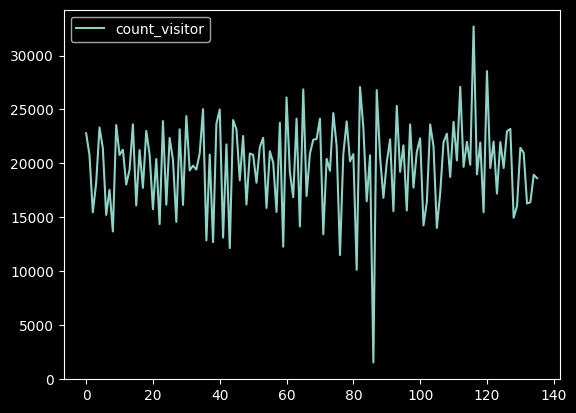

In [78]:
t.plot()

In [112]:
#Было сказано, что данные за 4,5 месяца. Блин а какие месяца. И посмотрим еще на распределения по количеству событий в каждый месяц
sql_month = '''
with date_events_count as (
  select strftime('%d', timestamp) as day, strftime('%m', timestamp) as month, count(1) as event
  from data_events
  group by 1, 2
)
select month, event
from date_events_count
group by 1
'''

sql_day = '''
with date_events_count as (
  select strftime('%d', timestamp) as day, strftime('%m', timestamp) as month, count(1) as event
  from data_events
  group by 1, 2
)
select day, event
from date_events_count
group by 1
'''

t_month = select(sql_month)
t_day = select(sql_day)

<BarContainer object of 5 artists>

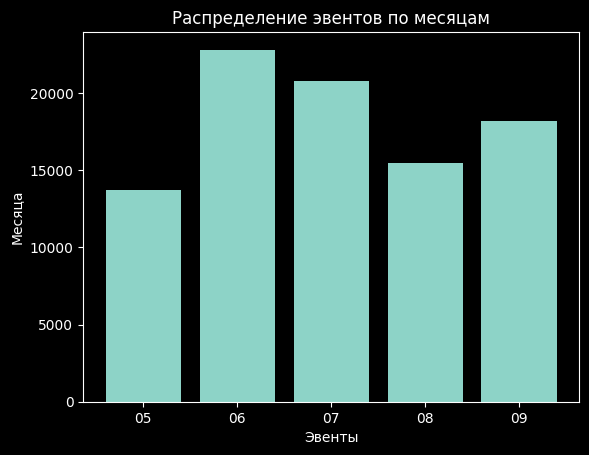

In [140]:
plt.title("Распределение эвентов по месяцам")
plt.xlabel("Эвенты")
plt.ylabel("Месяца")
plt.bar(t_month['month'], t_month['event'])

Посмотрим на другие таблицы (не являются ли они таблицами измерений?)

In [144]:
sql = '''
select *
from data_category
'''

select(sql).head(5) # похоже на еще одну таблицу фактов

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


In [30]:
# Это таблица измерений связывается с таблицей фактов через itemid
sql = '''
select *
from data_item_properties_part_1
limit 5
'''

select(sql)

,timestamp,itemid,property,value
0,2015-06-28 03:00:00,460429.0,categoryid,1338
1,2015-09-06 03:00:00,206783.0,888,1116713 960601 n277.200
2,2015-08-09 03:00:00,395014.0,400,n552.000 639502 n720.000 424566
3,2015-05-10 03:00:00,59481.0,790,n15360.000
4,2015-05-17 03:00:00,156781.0,917,828513


In [31]:
# Аналогично
sql = '''
select *
from data_item_properties_part_2
limit 5
'''

select(sql)
# все неточности в данных сможем обработать с помощью Power Query в PowerBI

,timestamp,itemid,property,value
0,2015-05-31 03:00:00,183478.0,561,769062
1,2015-08-16 03:00:00,132256.0,976,n26.400 1135780
2,2015-06-28 03:00:00,420307.0,921,1149317 1257525
3,2015-05-17 03:00:00,403324.0,917,1204143
4,2015-06-28 03:00:00,230701.0,521,769062


In [34]:
# Похоже на вспомогательную таблицу
sql = '''
select *
from data_category
limit 5
'''

select(sql)

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


Отлично, можно переходить к следующему этапу разработки дашборда!